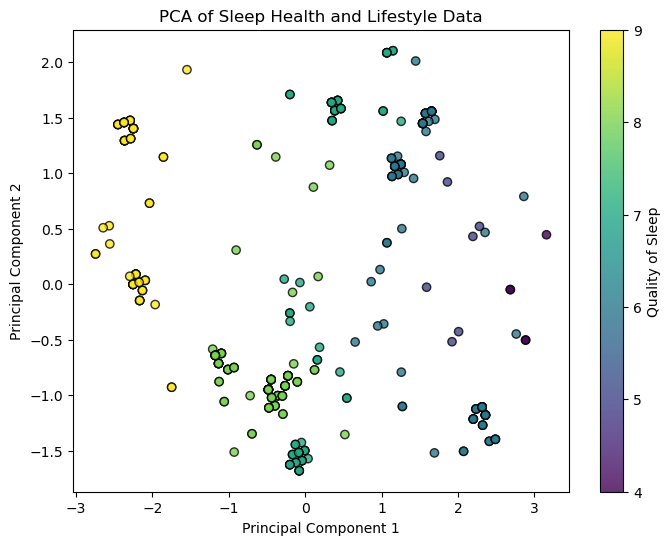

Explained variance ratio (first 2 components): [0.43692127 0.26281485]


In [18]:
# import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming df_subset contains your dataset after preprocessing
# Define features (X) and target variable (y)
X = df_subset.drop('Quality of Sleep', axis=1)  # Features
y = df_subset['Quality of Sleep']  # Target variable

# Standardize the feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.8)
plt.colorbar(label='Quality of Sleep')  # Colorbar indicating the target variable
plt.title('PCA of Sleep Health and Lifestyle Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print explained variance ratio
print("Explained variance ratio (first 2 components):", pca.explained_variance_ratio_)


C:\Users\mpe09\AppData\Local\Temp\ipykernel_15808\3765857626.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Sleep Disorder'] = df_subset['Sleep Disorder'].replace(sleep_disorder_mapping)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished


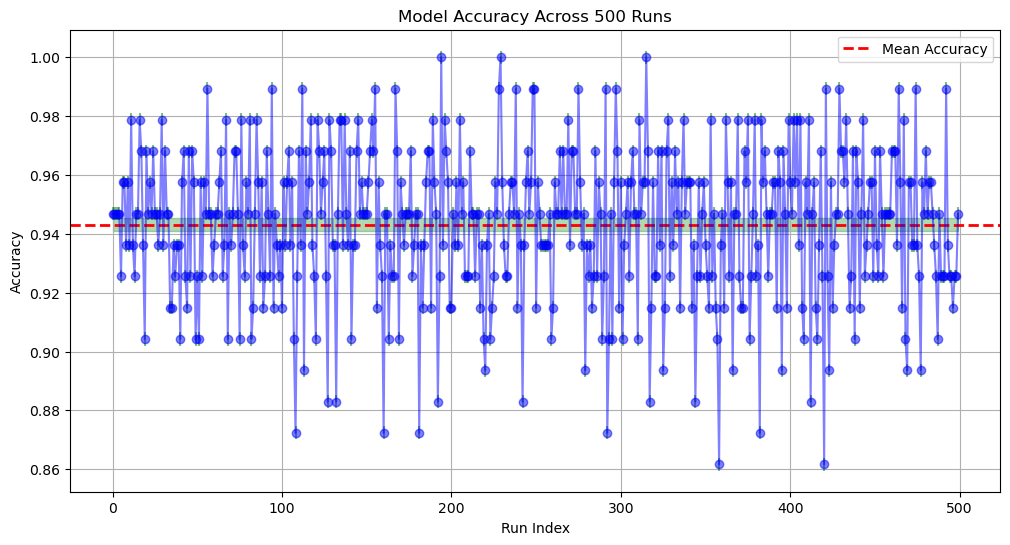

Mean Accuracy: 0.9431276595744682


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Define relevant columns including 'Sleep Disorder'
columns_of_interest = ['Age', 'Sleep Duration', 'Stress Level', 'Physical Activity Level', 'Sleep Disorder', 'Quality of Sleep']
df_subset = df[columns_of_interest]

# Replace missing values in 'Sleep Disorder' with 'None' (explicitly modify original DataFrame)
df_subset.loc[df_subset['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Map Sleep Disorder to numerical values (None: 0, Sleep Apnea: 1, Insomnia: 2)
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
df_subset['Sleep Disorder'] = df_subset['Sleep Disorder'].replace(sleep_disorder_mapping)

# Define features (X) and target variable (y)
X = df_subset.drop('Quality of Sleep', axis=1)
y = df_subset['Quality of Sleep']

# Number of parallel runs
n_runs = 500

# Function to train and evaluate the logistic regression model
def train_and_evaluate_model(seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=1000, C=1000, solver='newton-cg')
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run the logistic regression model multiple times in parallel
results = Parallel(n_jobs=-1, verbose=1)(delayed(train_and_evaluate_model)(seed) for seed in range(n_runs))

# Convert results to numpy array
results_array = np.array(results)

# Calculate mean and confidence interval
mean_accuracy = np.mean(results_array)
std_deviation = np.std(results_array)
margin_of_error = 1.96 * (std_deviation / np.sqrt(n_runs))  # 95% confidence interval

# Create indices for the runs
indices = np.arange(n_runs)

# Plot the mean accuracy with confidence interval using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(indices, results_array, yerr=margin_of_error, fmt='o', linestyle='-', color='b', ecolor='g', alpha=0.5)
plt.fill_between(indices, mean_accuracy - margin_of_error, mean_accuracy + margin_of_error, color='g', alpha=0.3)
plt.axhline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Run Index')
plt.ylabel('Accuracy')
plt.title(f'Model Accuracy Across {n_runs} Runs')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Accuracy: {mean_accuracy}")


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Define relevant columns including 'Sleep Disorder'
columns_of_interest = ['Age', 'Sleep Duration', 'Stress Level', 'Physical Activity Level', 'Sleep Disorder', 'Quality of Sleep']
df_subset = df[columns_of_interest]

# Replace missing values in 'Sleep Disorder' with 'None' (explicitly modify original DataFrame)
df_subset.loc[df_subset['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Map Sleep Disorder to numerical values (None: 0, Sleep Apnea: 1, Insomnia: 2)
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
df_subset['Sleep Disorder'] = df_subset['Sleep Disorder'].replace(sleep_disorder_mapping)

# Define features (X) and target variable (y)
X = df_subset.drop('Quality of Sleep', axis=1)
y = df_subset['Quality of Sleep']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the logistic regression model
logistic_reg = LogisticRegression(max_iter=10000)

# Define the grid of parameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Inverse regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


C:\Users\mpe09\AppData\Local\Temp\ipykernel_15808\1475600793.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Sleep Disorder'] = df_subset['Sleep Disorder'].replace(sleep_disorder_mapping)
B:\dev\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Parameters: {'C': 1000, 'solver': 'newton-cg'}
Best CV Score: 0.9464406779661017
Test Accuracy: 0.9866666666666667
